# An analysis of the State of the Union speeches - Part 4

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
import shelve

plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (10, 6)

Again, load data we need from previous parts without redoing that work.

In [71]:
with shelve.open('results/vars3') as db:    
    all_uq_words = db['unique_words']
    vocab_list = db['vocab_list']

addresses_df = pd.read_hdf('results/df3.addresses_df_3.h5', 'addresses_df')
speech_matrix = pd.read_hdf('results/df3.speech_matrix_3.h5', 'speech_matrix')
wmat = pd.read_hdf('results/df3.h5', 'wmat')

## Distance between speeches

### By President

Let's first compute a few useful things we'll need later, like the unique set of all presidents and their initials (for plot labeling).

Now, make a dataframe that will contain the word counts aggregated by president:

In [3]:
#we want to make a list of the unique president names
#BUT, we don't use a set here because we want to preserve the time-wise ordering of the presidents
president_names = []
for name in speech_matrix['President']: 
    if name not in president_names: 
        president_names.append(name)
        
initials = []
for i in range(len(president_names)):
    name=list(president_names[i])
    name=[letter for letter in name if letter.isupper()]
    initials.append(''.join(name))

In [72]:
president_speech_matrix = speech_matrix.groupby('President').sum()
speech_matrix.head()

,President,Date,ox,sole,puriti,shower,cleland,"25,364,500",behr,seafar,...,formid,aloof,"4,928,677.74",certif,checker,stat.,"3,330,543.87",cane,self-respect,teacher
0,George Washington,1790-01-08 00:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,George Washington,1790-12-08 00:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,George Washington,1791-10-25 00:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,George Washington,1792-11-06 00:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,George Washington,1793-12-03 00:00:00,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


And `pmn` is a normalized version that turns counts into probability distributions:

In [74]:
president_speech_matrix.head()

,ox,sole,puriti,shower,cleland,"25,364,500",behr,seafar,pare,leadersa,...,formid,aloof,"4,928,677.74",certif,checker,stat.,"3,330,543.87",cane,self-respect,teacher
President,,,,,,,,,,,,,,,,,,,,,
Abraham Lincoln,0,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Andrew Jackson,0,7,5,0,0,0,0,0,0,0,...,2,1,0,3,0,0,0,0,2,0
Andrew Johnson,0,3,2,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Barack Obama,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27
Benjamin Harrison,0,5,1,0,0,0,0,0,0,0,...,1,0,0,16,0,0,0,0,1,1


In [23]:
def normalize(X):
    """Standardize a matrix X"""
    return((X / X.sum(0)))

pmn = normalize(president_speech_matrix.transpose())

Sanity check: all columns should sum to 1.

In [25]:
pmn.sum()

President
Abraham Lincoln          1.0
Andrew Jackson           1.0
Andrew Johnson           1.0
Barack Obama             1.0
Benjamin Harrison        1.0
Calvin Coolidge          1.0
Chester A. Arthur        1.0
Donald J. Trump          1.0
Dwight D. Eisenhower     1.0
Franklin D. Roosevelt    1.0
Franklin Pierce          1.0
George H.W. Bush         1.0
George W. Bush           1.0
George Washington        1.0
Gerald R. Ford           1.0
Grover Cleveland         1.0
Harry S. Truman          1.0
Herbert Hoover           1.0
James Buchanan           1.0
James Madison            1.0
James Monroe             1.0
James Polk               1.0
Jimmy Carter             1.0
John Adams               1.0
John F. Kennedy          1.0
John Quincy Adams        1.0
John Tyler               1.0
Lyndon B. Johnson        1.0
Martin Van Buren         1.0
Millard Fillmore         1.0
Richard Nixon            1.0
Ronald Reagan            1.0
Rutherford B. Hayes      1.0
Theodore Roosevelt       1.0
Thom

Next, we'll compute distance matrices. Here, a distance matrix $M$ is a matrix such that $M_{i, j}$ is the distance from president $i$ to president $j$. We use two metrics: Euclidean distance and Jensen-Shannon divergence.

In [13]:
## Create Euclidean distance matrix
def distance_matrix_euclidean(data, function):
    distance_mat = np.zeros(shape=(len(data.T), len(data.T)))
    for i in range(0,len(data.T)):
        for j in range(0,i):
            distance_mat[i][j] = function(data.iloc[:,i] - data.iloc[:,j])
            distance_mat[j][i] = distance_mat[i][j]
    return(distance_mat)
euc_dis = distance_matrix_euclidean(pmn, np.linalg.norm)

We use the given JSdiv function below as-is, it already works.

In [18]:
from scipy.stats import entropy

def JSdiv(p, q):
    """Jensen-Shannon divergence.
    
    Compute the J-S divergence between two discrete probability distributions.
    
    Parameters
    ----------
    
    p, q : array
        Both p and q should be one-dimensional arrays that can be interpreted as discrete
        probability distributions (i.e. sum(p) == 1; this condition is not checked).
        
    Returns
    -------
    float
        The J-S divergence, computed using the scipy entropy function (with base 2) for
        the Kullback-Leibler divergence.
    """
    m = (p + q) / 2
    return (entropy(p, m, base=2.0) + entropy(q, m, base=2.0)) / 2

In [90]:
#Create JS distance matrix
def distance_matrix_JS(data, function):
    distance_mat = np.zeros(shape=(len(data.T), len(data.T)))
    for i in range(0,len(data.T)):
        for j in range(0,i):
            distance_mat[i][j] = function(data.iloc[:,i], data.iloc[:,j])
            distance_mat[j][i] = distance_mat[i][j]
    return(distance_mat)
JS_dis = distance_matrix_JS(pmn, JSdiv)


numpy.ndarray

Also, we make a numpy array version to use with Scikit-Learn:

In [29]:
# YOUR CODE HERE
pmn_numpy = np.array(pmn.iloc[:, :])

This is a "naive" plot where we use the $L^2$ distance to build the embedding.

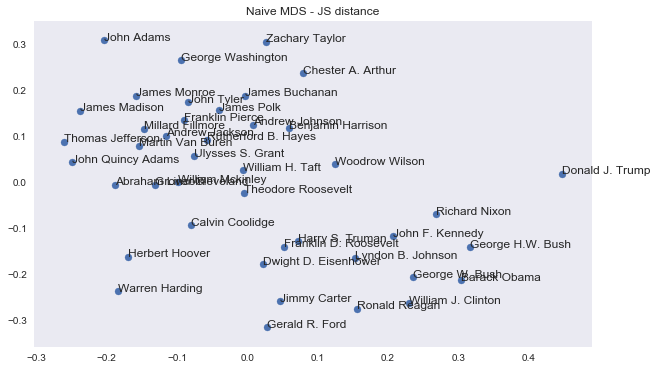

In [33]:
from sklearn.manifold import MDS
from sklearn import manifold


# intitialize
MDS =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with euclidean distance
lower_euc = MDS.fit_transform(euc_dis)

MDS =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with euclidean distance
lower_JS = MDS.fit_transform(JS_dis)

euc_points = MDS.fit_transform(euc_dis) #Euclidean MDS points
JS_points = MDS.fit_transform(JS_dis)
fig, ax = plt.subplots()
ax.scatter(JS_points[:,0], JS_points[:,1])
ax.set_title('Naive MDS - JS distance')
for i, txt in enumerate(list(pmn.columns)):
    ax.annotate(txt, (JS_points[i,0], JS_points[i,1]))

This will be more informative if we make a little utility function for the plots, that carries a legend, annotates each point with the president's initials, and colors them all:

In [51]:
# pres_names = pd.DataFrame(list(pmn.columns))
# JS_points_df = pd.DataFrame((JS_points))
# pres_names['tmp'] = range(0,42)
# JS_points_df['tmp'] = range(0,42)
# df = pd.merge(JS_points_df, pres_names, on=['tmp'], how='outer')
# df = df.drop('tmp', axis=1)
# df.columns = ['x', 'y', 'President']


#Create dataframe builder data frame
def build_dataframe(d1, d2):
    df1 = pd.DataFrame(d1)
    df2 = pd.DataFrame(d2)
    df1['tmp'] = range(0,len(df1))
    df2['tmp'] = range(0,len(df2))
    df = pd.merge(df1, df2, on = ['tmp'], how = 'outer')
    df = df.drop('tmp', axis = 1)
    df.columns = ['x', 'y', 'President']
    df['President'] = df.President.str.title()
    return df

JS_MDS_df = build_dataframe(JS_points, president_names)
Euc_MDS_df = build_dataframe(euc_points, president_names)

#sns.lmplot(x = df['x_coordinate'], y = df['y_coordinate'], data = df['President'])
#df.sort_index(df.iloc['x_coordinate'])
#df.sort_values(df['x_coordinate'])
# columns = ['x_coordinate', 'y_coordinate']
# df[columns] = df[columns].astype(int)


# fig, ax = plt.subplots()
# sns.lmplot(x = 'x_coordinate', y = 'y_coordinate', data = df, hue = 'President', fit_reg=False)
# pmn.columns
# for i, txt in enumerate(list(pmn.columns)):
#    ax.annotate(txt, (JS_points[i,0], JS_points[i,1]))
# enumerate(list(pmn.columns))

In [31]:
# sns.lmplot("x_coordinate","y_coordinate", df)

In [37]:
def plot_embedding(data, title='MDS Embedding', savepath=None, palette='viridis', 
                   size=7, annotate='initials'):
    """Plot an MDS embedding dataframe for all presidents.
    
    Uses Seaborn's `lmplot` to create an x-y scatterplot of the data, encoding the 
    value of the `President` field into the hue (which can be mapped to any desired
    color palette).
    
    Parameters
    ----------
    data : DataFrame
        A DataFrame that must contain 3 columns labeled 'x', 'y' and 'President'.
        
    title : optional, string
        Title for the plot
        
    savepath : optional, string
        If given, a path to save the figure into using matplotlib's `savefig`.
        
    palette : optional, string
        The name of a valid Seaborn palette for coloring the points.
    
    size : optional, float
        Size of the plot in inches (single number, square plot)
        
    annotate: optional, 'initials', 'name' or False
        If 'initials', annotate each point with the intials of each president,
        if 'name', use their last name, and if False, do not annotate at all.
        
    Returns
    -------
    FacetGrid
        The Seaborn FacetGrid object used to create the plot.
    """
    pres_name=list(data['President'])
    initials = []
    for i in range(len(pres_name)):
        name=list(pres_name[i])
        name=[letter for letter in name if letter.isupper()]
        initials.append(''.join(name))
    # get last name of president
    last_name=[name.split(' ')[-1] for name in pres_name]

    g=sns.lmplot(x = 'x', y = 'y', data = data, hue = 'President', fit_reg=False,
                palette=palette, legend=False, size=size)#, scatter_kws={"s:100"})

    g.add_legend(ncol=2)

    #add annotation
    if annotate == 'initials':
        for i, txt in enumerate(initials):
            plt.annotate(txt, (data.iloc[i, 'x'], data.loc[i, 'y']))
            
    elif annotate == 'name':
        
        for i, txt in enumerate(last_name):
            plt.annotate(txt, (data.loc[i, 'x'], data.loc[i,'y']))
    plt.grid()
    
    if title:
        plt.title(title)
        
    if savepath:
        plt.savefig(savepath)
    

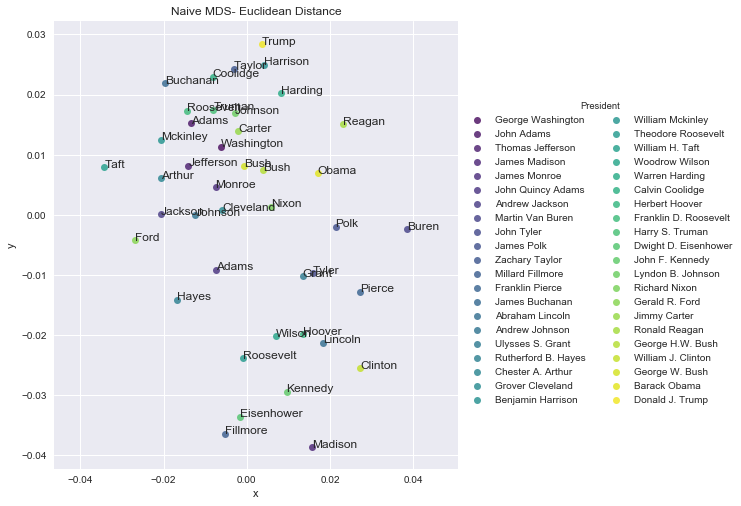

In [38]:
# plot_embedding(df)
plot_embedding(Euc_MDS_df, title="Naive MDS- Euclidean Distance", savepath='fig/mds_naive.png', annotate='name')

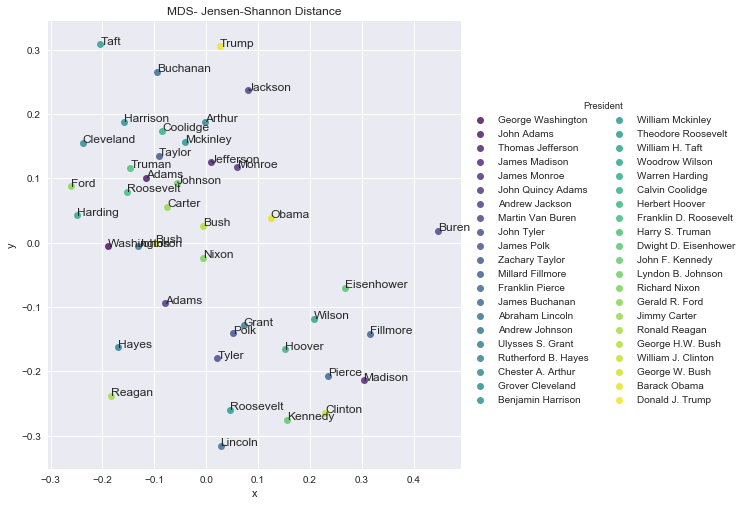

In [39]:
plot_embedding(JS_MDS_df, 'MDS- Jensen-Shannon Distance', 'fig/mds_jsdiv.png', annotate = 'name');

Now we use a distance metric defined on probability mass functions, the Jensen-Shannon Metric.

In [40]:
# plot_embedding(edf2, 'MDS - Jensen-Shannon Distance', 'fig/mds_jsdiv.png', annotate='name');


### By Speech
First we normalize the term-document matrix

We make a similar naive plot embedding using the $L^2$ distance.

In [70]:
speech_matrix.head()
# speech_matrix_ = speech_matrix.drop(['President', 'Date'], axis=1)
# len(speech_matrix_)

,ox,sole,puriti,shower,cleland,"25,364,500",behr,seafar,pare,leadersa,...,formid,aloof,"4,928,677.74",certif,checker,stat.,"3,330,543.87",cane,self-respect,teacher
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
def build_dataframe(d1, d2):
    df1 = pd.DataFrame(d1)
    df2 = pd.DataFrame(d2)
    df1['tmp'] = range(0,227)
    df2['tmp'] = range(0,len(df2))
    df = pd.merge(df1, df2, on = ['tmp'], how = 'outer')
    df = df.drop('tmp', axis = 1)
    df.columns = ['x', 'y', 'President']
    df['President'] = df.President.str.title()
    return df
speech_matrix_analysis = speech_matrix.drop(['President', 'Date'], axis=1)
speech_matrix_analysis.head()
all_pmn = normalize(speech_matrix_analysis.transpose())
all_pmn.head()
all_speeches_euclidean = distance_matrix_euclidean(all_pmn, np.linalg.norm)

all_speeches_JS = distance_matrix_JS(all_pmn, JSdiv)


TypeError: ufunc 'rel_entr' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [91]:
all_speeches_JS = distance_matrix_JS(all_pmn, JSdiv)

TypeError: 'numpy.ndarray' object is not callable

In [94]:
all_speeches_pres = list(speech_matrix['President'])
# intitialize
MDS =  manifold.MDS(dissimilarity="precomputed")
# transform to lower dimensional representation with euclidean distance


all_speeches_euc_points = MDS.fit_transform(all_speeches_euclidean) #all speeches Euclidean MDS points
#all_speeches_JS_points = MDS.fit_transform(all_speeches_JS_points) #all speeches JS MDS points
all_speeches_euc_MDS = build_dataframe(all_speeches_euclidean, all_speeches_pres)
#all_speeches_JS_MDS = all_speeches_pres(all_speeches_JS_points, all_speeches_pres)

ValueError: Length mismatch: Expected axis has 228 elements, new values have 3 elements

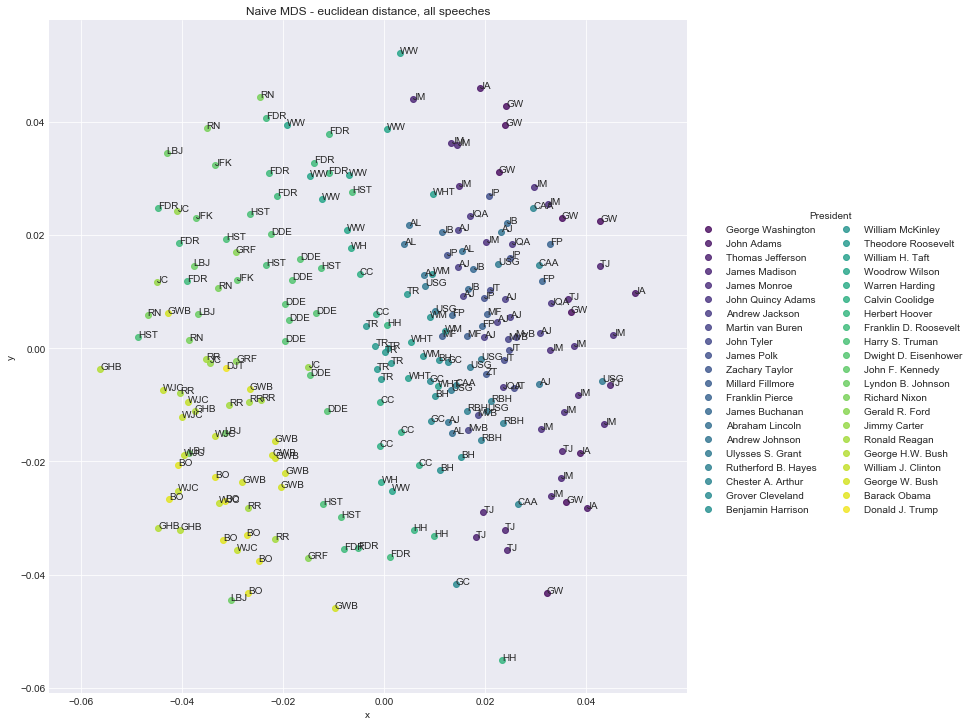

In [23]:

build_dataframe(speech_matrix, president_names)
plot_embedding(embed_df, 'Naive MDS - euclidean distance, all speeches',
               'fig/mds_naive_all.png', size=10);

Now with the Jensen-Shannon metric

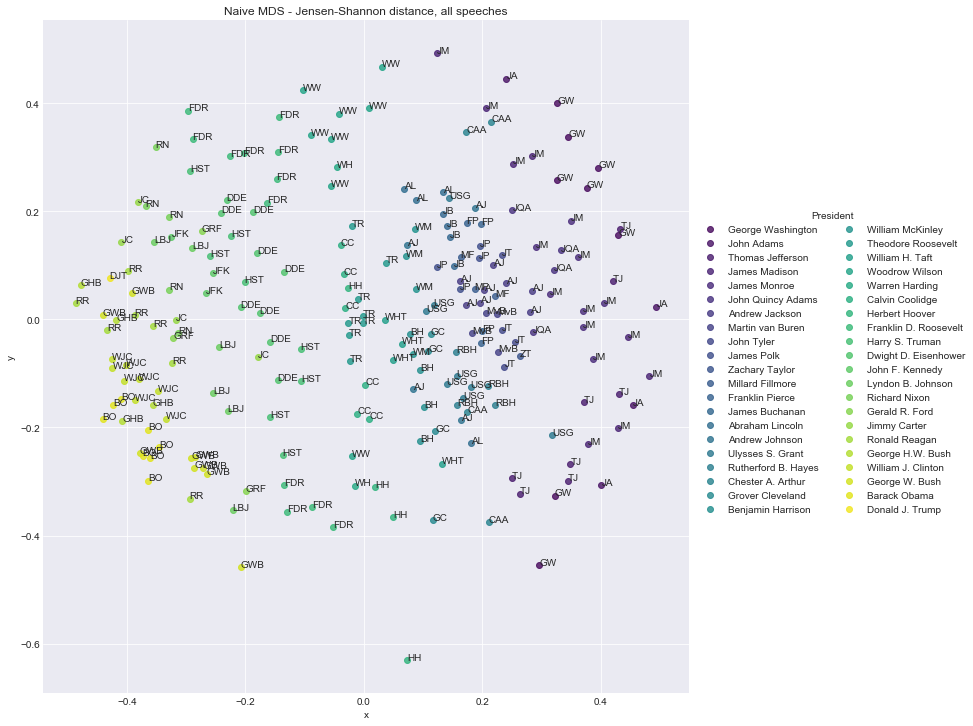

In [26]:
plot_embedding(embed_df2, 'Naive MDS - Jensen-Shannon distance, all speeches', 
               'fig/mds_jdsiv_all.png', size=10);

Store some final results. For native numpy arrays, we can use the convenient numpy `npz` container format, which behaves in practice similar to the Pandas HDF5 store and the Python Shelves:

In [27]:
np.savez('results/npa4.npz', pmm=pmm)